In [ ]:
#@title Install dependencies

!pip install pytorch-lightning
!pip install ipyplot
!pip install "git+https://github.com/broutonlab/deep-learning-course.git@dev"

import dl_course.transfer_learning.utils as courseutils

In [ ]:
#@title Download dataset
import ipyplot
import numpy as np
import pandas as pd
import torchvision
import pytorch_lightning as pl
import torchvision.transforms as T
import torch.nn as nn

In [ ]:
import torch

# [!] If cuda is not available,
# start using 'TPU' or 'GPU' in notebook settings
print(f'Cuda available: {torch.cuda.is_available()}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Describable Textures Dataset (DTD)

In this notebook we'll be classifying 47 (!) types of images based on human perception.  
This problem is a couple of magnitudes harded than the previous ones from our course.  
https://www.robots.ox.ac.uk/~vgg/data/dtd/

In [ ]:
import torchvision.datasets as t_datasets
from torch.utils.data import DataLoader

class DTDDataModule(pl.LightningDataModule):
    def __init__(self, imgsize, data_dir = "dataset/", batch_size = 16, num_workers = 2):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = T.Compose([T.ToTensor(), 
                                    T.Resize(size=imgsize)])

    def setup(self, stage = None):
        self.train = t_datasets.DTD(
            split='train', download=True, root=self.data_dir, transform=self.transform)
        self.val = t_datasets.DTD(
            split='val', download=True, root=self.data_dir, transform=self.transform)
        self.test = t_datasets.DTD(
            split='test', download=True, root=self.data_dir, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(
            self.train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(
            self.val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(
            self.test, batch_size=self.batch_size, num_workers=self.num_workers)
        
dummy_datamodule = DTDDataModule(imgsize=(256, 256))
classes = ["banded", "blotchy", "braided", "bubbly", "bumpy", "chequered", 
          "cobwebbed", "cracked", "crosshatched", "crystalline", "dotted", 
          "fibrous", "flecked", "freckled", "frilly", "gauzy", "grid", "grooved",
          "honeycombed", "interlaced", "knitted", "lacelike", "lined", "marbled",
          "matted", "meshed", "paisley", "perforated", "pitted", "pleated",
          "polka-dotted", "porous", "potholed", "scaly", "smeared", "spiralled",
          "sprinkled", "stained", "stratified", "striped", "studded", "swirly",
          "veined", "waffled", "woven", "wrinkled", "zigzagged"]

courseutils.preview_datamodule(dummy_datamodule, classes, num_samples=10)

# Introduction in transfer learning

Training a network takes a lot of resources (time, data and processing power).  
Thankfully, researchers usually make **weights** of their architectures available to the public.

This means that if you have a problem to solve, you can just use other people's weights as a starting point and retrain them to fit the task at hand.  
This generally requires less data and computing power than training a model from scratch.



# Approaches to transfer learning

First layers of a CNN usually learn low-level features that fit a huge range of problems. Oftentimes it doesn't make sense to retrain the entire model.  
*(Look at the picture below)*  
Leaving N first layers untouched (or **freezed**) and training the rest is a less demanding task.  

Depending on how far your problem lies from the model's original problem, the more retraining you'll have to do.  

We'll start by using the 3rd strategy and train only the classifier (last layer), leaving others frozen.

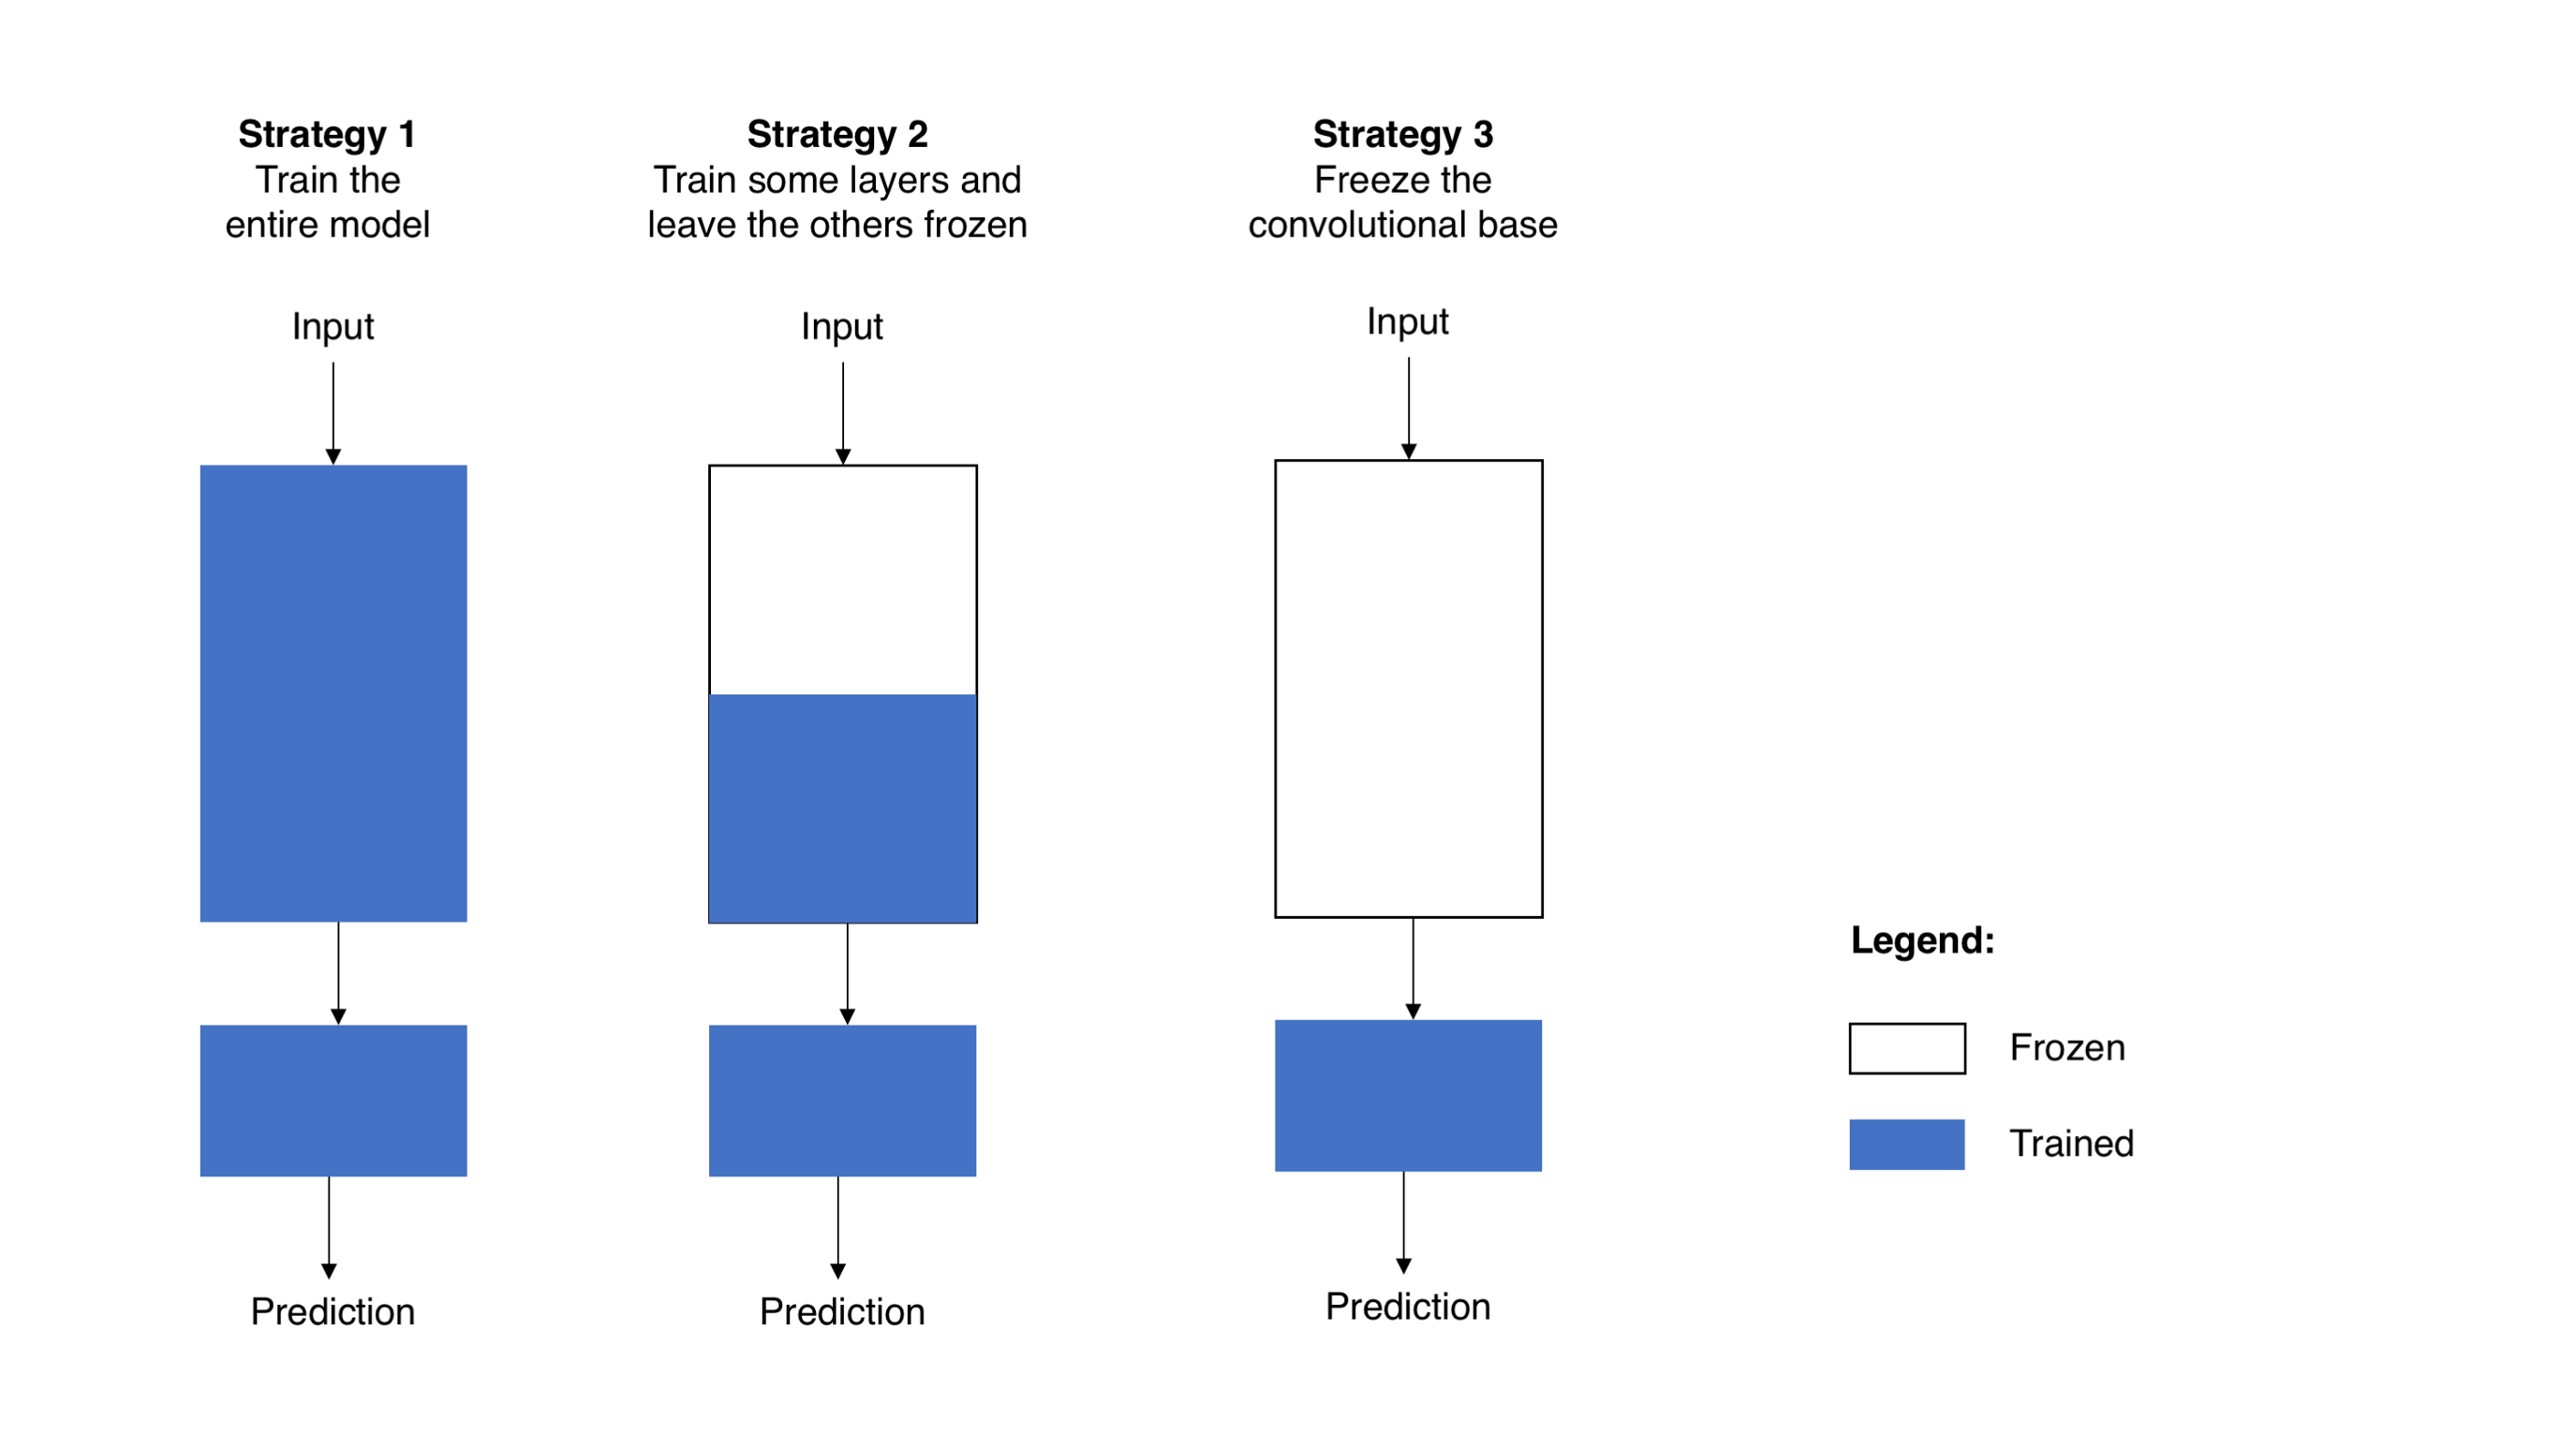

# PyTorch's pretrained models

There are plenty of resources to get pretrained models from (and we'll look into them later in the course!). For today's tutorial, we'll use PyTorch's built-in models. (https://pytorch.org/vision/stable/models.html)


In [ ]:
import torchvision.models as models
backbone = models.densenet121(weights='DEFAULT')

# Looking inside a model

Now we need to find a way to strip the last classification layer (it's output shape doesn't match our number of classes, we're throwing it away completely).

Sadly, there's no standard way of doing this. Every model is different.  

There are packages that can print out model summary (like this one https://github.com/TylerYep/torchinfo). We'll use `print()` for now. 

In [ ]:
print(backbone)

**Notice the `(classifier)` at the very bottom.**  
This is the layer we need to get rid of and replace with our own (with shape `(1024, 47)`, because we have 47 classes and it has to be compatible with previous layer)

# Create a model using existing architecture and weights

In [ ]:
import torchvision.models as models

class TextureClassifier(pl.LightningModule):
  def __init__(self, num_classes=47, learning_rate=1e-3):
    super().__init__()

    self.num_classes = num_classes
    self.learning_rate = learning_rate

    # load pretrained backbone model
    # you can view all model available through this API
    # at https://pytorch.org/vision/stable/models.html
    backbone = models.densenet121(weights='DEFAULT')

    # input shape of last linear layer.
    # layers names are different for each model,
    # use torchsummary or just print(backbone) to obtain them
    feat_num = backbone.classifier.in_features

    #strip last linear layer, use all the other ones
    layers = list(backbone.children())[:-1]
    self.backbone = nn.Sequential(*layers)

    # [!] Freeze each parameter of backbone model
    for param in self.backbone.parameters():
      param.requires_grad = False

    # ===============
    # [!] TODO: 
    # 	Implement final affine layer, 
    #   which is placed after the backbone architecture
    self.classifier = ...
    # ===============

  def forward(self, x):
    self.backbone.eval()
    # ===============
    # [!] 
    #   Both backbone.eval() and
    #   torch.no_grad() are used for freezing.
    # [!] 
    #   TODO: Implement forward pass of the model
    #   Hint: before classifier, 
    #   use .flatten(1) as we did in previous tutorial
    with torch.no_grad():
      ...
    
    return ...
    # ===============


  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    return optimizer
  
  def loss_fn(self, y_hat, target):
    return nn.CrossEntropyLoss()(y_hat, target)
   
  def _eval_step(self, x, y):
    y_hat = self.forward(x)
    loss = self.loss_fn(y_hat, y)
    return y_hat, loss

  def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat, loss = self._eval_step(x, y)
    self.log('train_loss', loss)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat, loss = self._eval_step(x, y)
    self.log('val_loss', loss)

  def test_step(self, batch, batch_idx):
    x, y = batch
    y_hat, loss = self._eval_step(x, y)

    _, preds = torch.max(y_hat, 1)
    correct = torch.sum(preds == y)

    return {'test_loss': loss, 'correct': correct, 'num_entries': x.shape[0]}

  def test_epoch_end(self, outputs):
    avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()

    avg_acc = torch.stack([x['correct'].float() for x in outputs]).sum() \
						/ sum(output['num_entries'] for output in outputs)

    logs = {'test_loss': avg_loss, 'test_acc': avg_acc}
    self.log_dict(logs)

In [ ]:
# Change this if you need to scale images to a different size!
imgsize = (32, 32)

In [ ]:
# test your implementation
model = TextureClassifier(num_classes=47)
dummy_image = torch.rand(size=(1, 3, *imgsize))
y_hat = model.forward(dummy_image)
dummy_loss = torch.sum(y_hat)
dummy_loss.backward()
assert(
    all(
        layer.weight.grad is None 
        for layer in dict(model.backbone.named_modules()).values()
        if hasattr(layer, 'weight')
        )
    )
assert(model.classifier.weight.grad is not None)


# Let's train our classifier layer

You should see that the majority of the parameters are marked as 'non-trainable'.

In [ ]:
logger = pl.loggers.TensorBoardLogger("tb_logs", name="texture_cnn")
model = TextureClassifier(num_classes=47, learning_rate=1e-3)
datamodule = DTDDataModule(imgsize=imgsize, batch_size=32)

trainer = pl.Trainer(accelerator='gpu', devices=-1, max_epochs=6, logger=logger, log_every_n_steps=10)
trainer.fit(model=model, datamodule=datamodule)

# Let's evaluate our model!

In [ ]:
trainer.test(model=model, datamodule=datamodule)

In [ ]:
courseutils.test_model_on_datamodule(model, datamodule, classes, device='cuda', num_images=10)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir tb_logs/

# Results

You should get about 24% accuracy.
This is better than pure random (1/47 = ~0.02), but is still bad.

This is because we've compressed the images quite a lot (original images are more than 300x300 pixels in size instead of 32x32) to fit into a poor backbone.


# Home task

## 1. Choose a different backbone

You'll see a major increase in performance, once you switch to a really powerful architecture.  
[ ! ] Don't forget to change image size to what your new model needs.  
These two actions alone should get you to about 70% accuracy.  
Don't forget to change the number of epochs and avoid overfitting!

Beware that not all models will work with our code, because we ignore functional API when passing the layers to ```nn.Sequential```. For example, ViT needs a different approach.

## 2. Try a different strategy

Right now we're just training the last layer (strategy 3 on our picture in the begging). But we could as well train the last N layers of the backbone model.

## 3. Add augmentations

You're already good at this since our CNN notebook.
